In [1]:
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.backend import default_experiment_result_function
from qiskit_dynamics.array import Array
import jax
from qiskit.providers.fake_provider import *

/home/riccardo/.venv/lib/python3.10/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.backend import default_experiment_result_function
from qiskit_dynamics.array import Array
import jax
from qiskit.providers.fake_provider import *

gate_backend = FakeManila()
gate_backend.configuration().hamiltonian['qub'] = {'0': 2,'1': 2,'2': 2,'3': 2,'4': 2}
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")
pulse_backend = DynamicsBackend.from_backend(gate_backend, evaluation_mode="sparse")
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}
pulse_backend.set_options(solver_options=solver_options)
pulse_backend.configuration = lambda: gate_backend.configuration()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


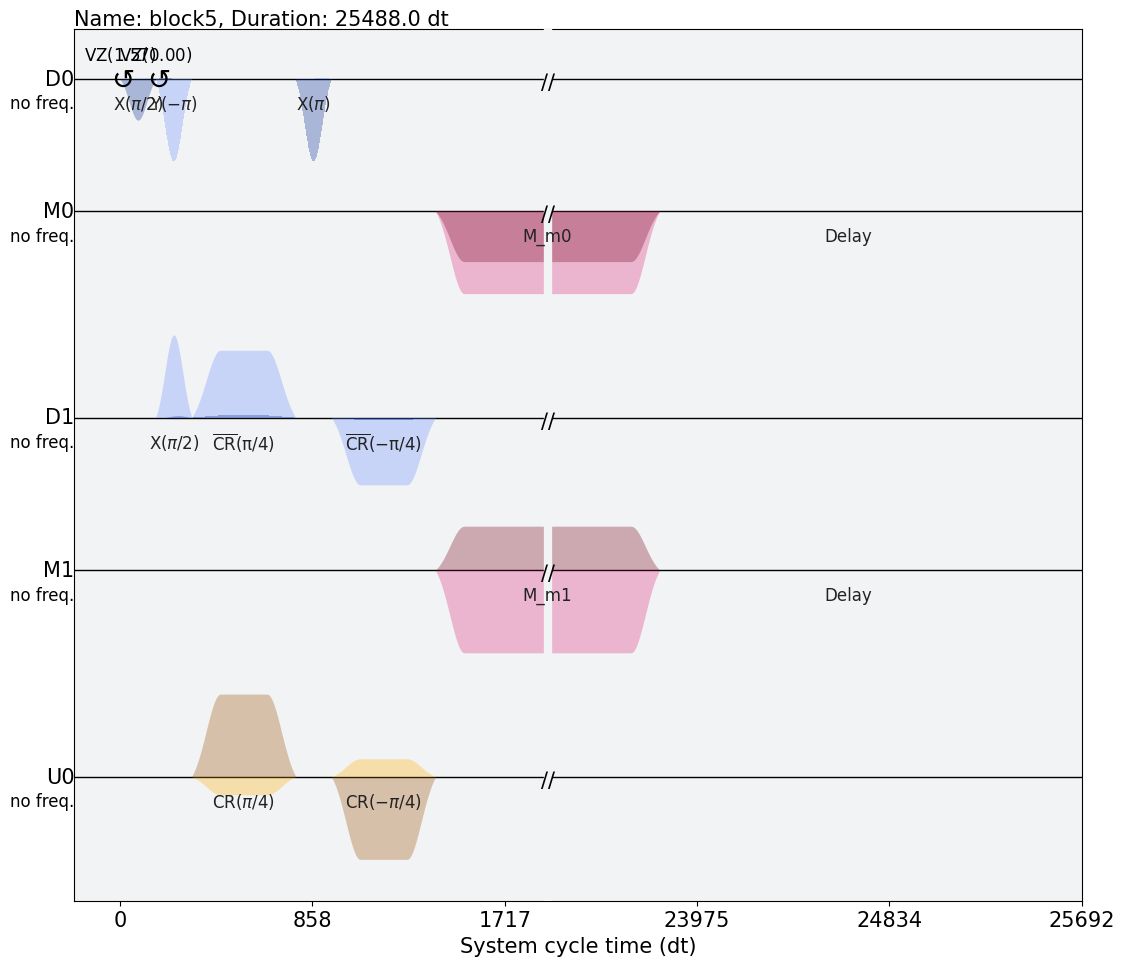

In [3]:
from qiskit import QuantumCircuit, pulse
from qiskit_dynamics.backend import DynamicsBackend

qc_test = QuantumCircuit(2)
qc_test.h(0)
qc_test.cx(0,1)
qc_test.measure_all()
with pulse.build(gate_backend) as pulse_test:
  pulse.call(qc_test)

pulse_test.draw()

In [4]:
results = pulse_backend.run(pulse_test).result()
counts = results.get_counts()
print(counts)

{'00': 144, '01': 230, '10': 128, '11': 522}


In [5]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np

# Definisci la stringa che rappresenta la molecola semplificata di H2
simplified_h2_molecule = """
H 0.0 0.0 0.0
H 0.0 0.0 0.735
"""

# Configura il driver PySCF per generare la rappresentazione quantistica della molecola
driver = PySCFDriver(
    atom=simplified_h2_molecule.strip(),
    basis='sto3g',
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)

# Esegui il driver per ottenere la rappresentazione quantistica della molecola (Qmol)
qmolecule = driver.run()

/home/riccardo/.venv/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [6]:
from qiskit_nature import settings
settings.use_pauli_sum_op = False
#from qiskit_nature.second_q.mappers import QubitConverter (DEPRECATED)

# Ottieni l'Hamiltoniana dalla molecola quantistica precedentemente calcolata
hamiltonian = qmolecule.hamiltonian

# Estrai i coefficienti degli integrali elettronici dall'Hamiltoniana
coefficients = hamiltonian.electronic_integrals

# Ottieni l'operatore quantistico di secondo quantizzazione dall'Hamiltoniana
second_q_op = hamiltonian.second_q_op()

# Usa il mapper di Parity per mappare l'operatore quantistico ai qubit
mapper = ParityMapper()
##############################################################################################################################
# Crea un convertitore Qubit basato sul mapper e abilita la riduzione a due qubit
#converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

# Converte l'operatore quantistico di secondo quantizzazione al formato di qubit
#qubit_op = converter.convert(second_q_op)
###############################################################################################################################
qubit_op = mapper.map(second_q_op) #<-----------------------------

# Stampa l'operatore quantistico ottenuto
print(qubit_op)

# Inizializza un dizionario vuoto per memorizzare le informazioni sugli operatori di Pauli
dict = {}

# Itera attraverso gli operatori di Pauli nell'operatore quantistico
for pauli_op in qubit_op.to_pauli_op().oplist:   
    str_info = pauli_op.__str__()

    # Estrai il coefficiente e la parte finale della stringa che rappresenta l'operatore di Pauli
    # e salva il coefficiente nel dizionario utilizzando la parte finale come chiave
    dict[str_info[-4:]] = float(str_info[0:-6])

SparsePauliOp(['IIII', 'IIIZ', 'IIZZ', 'IZZI', 'ZZII', 'IIZI', 'IZZZ', 'ZZIZ', 'ZXIX', 'IXZX', 'ZXZX', 'IXIX', 'IZIZ', 'ZZZZ', 'ZIZI'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.16614543+0.j,
  0.0452328 +0.j, -0.0452328 +0.j, -0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


AttributeError: 'SparsePauliOp' object has no attribute 'to_pauli_op'

In [7]:
from qiskit.pulse import Schedule, GaussianSquare, Drag, Delay, Play, ControlChannel, DriveChannel

def drag_pulse(backend, amp, angle):
    # Ottieni le impostazioni predefinite del backend
    backend_defaults = backend.defaults()

    # Ottieni la mappatura delle istruzioni dal backend
    inst_sched_map = backend_defaults.instruction_schedule_map

    # Estrai l'impulso di base per la porta X sulla qubit 0
    x_pulse = inst_sched_map.get('x', (0)).filter(channels=[DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse

    # Estrai i parametri necessari dall'impulso di base
    duration_parameter = x_pulse.parameters['duration']
    sigma_parameter = x_pulse.parameters['sigma']
    beta_parameter = x_pulse.parameters['beta']

    # Costruisci un impulso Drag utilizzando i parametri estratti e i nuovi parametri amp e angle
    pulse1 = Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp, angle=angle)

    return pulse1

def cr_pulse(backend, amp, angle, duration):
    # Ottieni le impostazioni predefinite del backend
    backend_defaults = backend.defaults()

    # Ottieni la mappatura delle istruzioni dal backend
    inst_sched_map = backend_defaults.instruction_schedule_map

    # Estrai l'impulso di base per la porta CX tra qubit 0 e 1
    cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels=[ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse

    # Estrai i parametri necessari dall'impulso di base
    cr_params = {
        'duration': cr_pulse.parameters['duration'],
        'amp': cr_pulse.parameters['amp'],
        'angle': cr_pulse.parameters['angle'],
        'sigma': cr_pulse.parameters['sigma'],
        'width': cr_pulse.parameters['width']
    }

    # Calcola i parametri aggiuntivi necessari per costruire un GaussianSquare pulse
    cr_risefall = (cr_params['duration'] - cr_params['width']) / (2 * cr_params['sigma'])
    angle_parameter = angle
    duration_parameter = duration
    sigma_parameter = cr_pulse.parameters['sigma']
    width_parameter = int(duration_parameter - 2 * cr_risefall * cr_params['sigma'])

    # Costruisci un GaussianSquare pulse utilizzando i parametri calcolati
    pulse1 = GaussianSquare(duration=duration_parameter, amp=amp, angle=angle_parameter, sigma=sigma_parameter, width=width_parameter)

    return pulse1


In [8]:
def HE_pulse(backend, amp, angle, width):
    # Crea un programma di impulsi vuoto
    with pulse.build(backend) as my_program1:
        # Lista di schedule per i vari layer
        sched_list = []

        # Layer 1: Applica una porta X su ciascun qubit
        with pulse.build(backend) as sched1:
            qubits = (0, 1, 2, 3)
            for i in range(4):
                pulse.play(drag_pulse(backend, amp[i], angle[i]), DriveChannel(qubits[i]))
            sched_list.append(sched1)

        # Layer 2: Applica una porta di controllo tra qubit 0 e 1
        with pulse.build(backend) as sched2:
            uchan = pulse.control_channels(0, 1)[0]
            pulse.play(cr_pulse(backend, amp[4], angle[4], width[0]), uchan)
            sched_list.append(sched2)

        # Layer 3: Applica una porta di controllo tra qubit 1 e 2
        with pulse.build(backend) as sched4:
            uchan = pulse.control_channels(1, 2)[0]
            pulse.play(cr_pulse(backend, amp[5], angle[5], width[1]), uchan)
            sched_list.append(sched4)

        # Layer 4: Applica una porta di controllo tra qubit 2 e 3
        with pulse.build(backend) as sched6:
            uchan = pulse.control_channels(2, 3)[0]
            pulse.play(cr_pulse(backend, amp[6], angle[6], width[2]), uchan)
            sched_list.append(sched6)

        # Costruisci il programma principale allineando sequenzialmente gli schedule
        with pulse.build(backend) as my_program:
            with pulse.transpiler_settings(initial_layout=[0, 1, 2, 3]):
                with pulse.align_sequential():
                    for sched in sched_list:
                        pulse.call(sched)

    return my_program


In [9]:
import copy
from scipy.optimize import minimize, LinearConstraint

def measurement_pauli(prepulse, pauli_string, backend, n_qubit):
    # Costruisci un programma di impulsi per la misurazione del Pauli operator
    with pulse.build(backend) as pulse_measure:
        pulse.call(copy.deepcopy(prepulse))  # Applica l'impulso di preparazione
        # Applica le porte X e Y in base al Pauli operator specificato
        for ind, pauli in enumerate(pauli_string):
            if pauli == 'X':
                pulse.u2(0, np.pi, ind)
            elif pauli == 'Y':
                pulse.u2(0, np.pi / 2, ind)
        # Aggiungi una barriera tra ciascun qubit
        for qubit in range(n_qubit):
            pulse.barrier(qubit)
        # Misura tutti i qubit
        pulse.measure(range(n_qubit))
    return pulse_measure

def n_one(bitstring, key):
    # Conta il numero di '1' nelle posizioni non corrispondenti a 'I' nel Pauli operator
    results = 0
    for ind, b in enumerate(reversed(bitstring)):
        if b == '1' and key[ind] != 'I':
            results += 1
    return results

def expectation_value(counts, shots, key):
    # Calcola il valore atteso in base alle misure e al Pauli operator
    results = 0
    for bitstring in counts:
        if n_one(bitstring, key) % 2 == 1:
            results -= counts[bitstring] / shots
        else:
            results += counts[bitstring] / shots
    return results

def run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot):
    # Esegui la simulazione del programma di impulsi e calcola il valore atteso
    results = pulse_backend.run(meas_pulse).result()
    counts = results.get_counts()
    expectation = expectation_value(counts, n_shot, key)
    return expectation

def gen_LC_vqe(parameters):
    # Genera un oggetto LinearConstraint per la minimizzazione con vincoli lineari
    lb = np.zeros(parameters)
    ub = np.ones(parameters)
    LC = LinearConstraint(np.eye(parameters), lb, ub, keep_feasible=False)
    return LC


In [10]:
def vqe_one(prepulse, n_qubit, n_shot, pulse_backend, backend, key, value):
    # Verifica se il Pauli operator è l'identità ('I'), restituendo immediatamente il valore associato
    all_Is = all(key_ele == 'I' for key_ele in key)
    if all_Is:
        return value

    # Costruisci un programma di impulsi per la misurazione del Pauli operator specificato
    meas_pulse = measurement_pauli(prepulse=prepulse, pauli_string=key, backend=backend, n_qubit=n_qubit)

    # Calcola il valore atteso utilizzando la simulazione del programma di impulsi
    return value * run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot)


In [11]:
def vqe(params, pauli_dict, pulse_backend, backend, n_qubit, n_shot):
    # Stampa i parametri in input
    print("params in def chemistry in vqe.py: ", params)

    # Calcola la lunghezza delle liste di ampiezze, angoli e larghezze
    width_len = int(len(params) - 1 * (n_qubit - 1))

    # Trova l'indice in cui si divide la lista delle larghezze
    split_ind = int(width_len / 2)

    # Estrai le ampiezze, gli angoli e le larghezze dalla lista dei parametri
    amp = np.array(params[:split_ind])
    angle = np.array(params[split_ind:width_len]) * np.pi * 2
    width_1 = np.array(params[width_len:])

    # Calcola il numero di intervalli di larghezza normalizzati
    num_items = (1024 - 256) // 16 + 1

    # Normalizza le larghezze tra 256 e 1024
    width_norm = (width_1 - 256) / (1024 - 256)
    width_norm = np.clip(width_norm, 0, 1)

    # Calcola le larghezze in base alla normalizzazione
    width = (np.round(width_norm * (num_items - 1)) * 16 + 256).astype(int)

    # Converti le variabili numpy in liste
    amp = amp.tolist()
    angle = angle.tolist()
    width = width.tolist()

    # Ottieni le chiavi e i valori dal dizionario di Pauli
    keys = [key for key in pauli_dict]
    values = [pauli_dict[key] for key in pauli_dict]

    # Calcola i valori attesi per ciascun operatore di Pauli
    expect_values = []
    for key, value in zip(keys, values):
        # Genera l'impulso di preparazione
        prepulse = HE_pulse(backend, amp, angle, width)

        # Calcola il valore atteso per l'operatore di Pauli corrente
        expect = vqe_one(prepulse, n_qubit, n_shot, pulse_backend, backend, key, value)
        expect_values.append(expect)

    # Stampa la somma dei valori attesi per l'iterazione corrente
    print("E for cur_iter: ", sum(expect_values))

    # Restituisci la somma dei valori attesi
    return sum(expect_values)


In [12]:
# Definisci il numero di qubit, il numero di parametri, e inizializza i parametri a zero
n_qubit = 1
parameters = 1
params = np.zeros(parameters)

# Genera un oggetto LinearConstraint per la minimizzazione con vincoli lineari
LC = gen_LC_vqe(parameters)

# Definisci il numero di misure (shots) e l'ottimizzatore da utilizzare
n_shot = 1024
optimizer = 'COBYLA'

# Esegui la minimizzazione della funzione VQE utilizzando il metodo specificato
vqe_res = minimize(vqe, params, args=(dict, pulse_backend, gate_backend, n_qubit, n_shot),
                   method=optimizer, constraints=LC, options={'rhobeg': 0.2, 'maxiter': 70, 'disp': True})

# Stampare il dizionario di operatori di Pauli
print(dict)

# Stampare il valore ottimizzato della funzione di perdita
print('The optimized loss func value: {}'.format(vqe_res.fun))

params in def chemistry in vqe.py:  [0.]
E for cur_iter:  0
params in def chemistry in vqe.py:  [0.2]
E for cur_iter:  0
params in def chemistry in vqe.py:  [0.025]
E for cur_iter:  0
params in def chemistry in vqe.py:  [0.003125]
E for cur_iter:  0
params in def chemistry in vqe.py:  [0.00039063]
E for cur_iter:  0
params in def chemistry in vqe.py:  [5.e-05]
E for cur_iter:  0
{}
The optimized loss func value: 0.0

   Normal return from subroutine COBYLA

   NFVALS =    6   F = 0.000000E+00    MAXCV =-0.000000E+00
   X = 0.000000E+00
